# Exercise 5 - Convolutional Neural Networks and the MNIST dataset
This exercise is based on https://github.com/leriomaggio/deep-learning-keras-tensorflow

In this exercise we want to solve the same multinomial classification problem as in last weeks exercise 4 using the MNIST dataset, but this time we want to use a convolutional neural network for it.


As usual we will load tensorflow 2 first and make sure we change our runtime to python 3:

In [ ]:
#Check if colab is running
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  %tensorflow_version 2.x

#import TF
import tensorflow as tf
from platform import python_version
print("Tensorflow version", tf.__version__)
print("Python version =",python_version())

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.15.0
Python version = 3.10.12


Before we start, we define a few useful functions, which we used in exercise 4:

In [ ]:
###################################################################################################

import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

###################################################################################################

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###################################################################################################
import matplotlib.cm as cm
def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=cm.Greys, interpolation='nearest')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

###################################################################################################


## Data Preparation

### Very Important:
When dealing with images & convolutions, you need to handle the `image_data_format` properly, i.e. is the channel given first or last. The channel axis is an additional dimension of the input data used to access different views of the date, e.g. red/green/blue of a color image, left or right of a stereo sound file).
For grayscale data, the channel dimension is 1, for rgb it should be 3.

In [ ]:
from tensorflow.keras import backend as K
K.image_data_format()

'channels_last'

In [ ]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)

In [ ]:
shape_ord

(28, 28, 1)

### Task 1: Data preprocessing
* Load the mnist data of the keras datasets
* Scale the design matrix to values between 0 and 1
* Convert the design matrix to the expected (60000, 28, 28, 1) shape
* Convert the target vector to one-hot-vectors for the 10 classes
* Split the training data into 70% training and 30% validation data sets

*hints*:
- remember the function from `tensorflow.keras.utils` you used in Exercise 4 to convert integer labels to one-hot-vectors
- pay attention to the input when scaling the desing matrix!  

### Loading Data

In [ ]:
#Import the required libraries
import numpy as np
np.random.seed(1338)  # for reproducibilty!!

from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


### Preprocess and Normalise Data

Convert the data to float, scale it with a MinMaxScaler and add the channel dimension

In [ ]:
X_train.shape

(60000, 28, 28)

Scaler need a 2D array, so we need to reshape it first

In [ ]:
X_train = X_train.reshape(X_train.shape[0],img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows*img_cols)
X_train.shape

(60000, 784)

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape

(60000, 784)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],img_rows,img_cols)
X_test = X_test.reshape(X_test.shape[0],img_rows,img_cols)
X_train.shape

(60000, 28, 28)

And finally to the expected (60000, 28, 28, 1) shape for the CNN

In [ ]:
X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

In [ ]:
X_train.shape

(60000, 28, 28, 1)

### Convert target vector

In [ ]:
from tensorflow.keras.utils import to_categorical
num_classes = 10
Y_train = to_categorical(y_train, num_classes)
Y_test = to_categorical(y_test, num_classes)
Y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

### Split Training and Validation Data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=42, stratify=Y_train)

## A simple convolutional neural network

#### Convolution2D

Convolution layers learn a set of *kernels* that they apply to the data. Our grayscale image have one channel. A 3x3 kernel trained on this data with 1 channel has 10 trainable parameters (3\*3\*1 weights + 1 bias weight for the output). If a 3x3 kernel is trained on e. g. data with 3 channels, this results in 3\*3\*3 +1 = 28 weights. A Conv-Layer can learn more than just one kernel. The number of different kernels are the number of *filters* passed to the layer constructor. Each filter produces an output channel from the input data.

<img src=https://cntk.azurewebsites.net/jup/cntk103d_conv2d_final.gif width=300></img>
(taken from [CNTK Documentation](https://cntk.azurewebsites.net/pythondocs/CNTK_103D_MNIST_ConvolutionalNeuralNetwork.html))
```python
from tensorflow.keras.layers import Conv2D

Conv2D(filters, kernel_size, strides=(1, 1), padding='valid',
       data_format=None, dilation_rate=(1, 1), activation=None,
       use_bias=True, kernel_initializer='glorot_uniform',
       bias_initializer='zeros', kernel_regularizer=None,
       bias_regularizer=None, activity_regularizer=None,
       kernel_constraint=None, bias_constraint=None)
```

#### Arguments:

<ul>
<li><strong>filters</strong>: Integer, the dimensionality of the output space
    (i.e. the number output of filters in the convolution).</li>
<li><strong>kernel_size</strong>: An integer or tuple/list of 2 integers, specifying the
    width and height of the 2D convolution window.
    Can be a single integer to specify the same value for
    all spatial dimensions.</li>
<li><strong>strides</strong>: An integer or tuple/list of 2 integers,
    specifying the strides of the convolution along the width and height.
    Can be a single integer to specify the same value for
    all spatial dimensions.
    Specifying any stride value != 1 is incompatible with specifying
    any <code>dilation_rate</code> value != 1.</li>
<li><strong>padding</strong>: one of <code>"valid"</code> or <code>"same"</code> (case-insensitive).</li>
<li><strong>data_format</strong>: A string,
    one of <code>channels_last</code> (default) or <code>channels_first</code>.
    The ordering of the dimensions in the inputs.
    <code>channels_last</code> corresponds to inputs with shape
    <code>(batch, height, width, channels)</code> while <code>channels_first</code>
    corresponds to inputs with shape
    <code>(batch, channels, height, width)</code>.
    It defaults to the <code>image_data_format</code> value found in your
    Keras config file at <code>~/.keras/keras.json</code>.
    If you never set it, then it will be "channels_last".</li>
<li><strong>dilation_rate</strong>: an integer or tuple/list of 2 integers, specifying
    the dilation rate to use for dilated convolution.
    Can be a single integer to specify the same value for
    all spatial dimensions.
    Currently, specifying any <code>dilation_rate</code> value != 1 is
    incompatible with specifying any stride value != 1.</li>
<li><strong>activation</strong>: Activation function to use
    (see <a href="https://keras.io/activations/">activations</a>).
    If you don't specify anything, no activation is applied
    (ie. "linear" activation: <code>a(x) = x</code>).</li>
<li><strong>use_bias</strong>: Boolean, whether the layer uses a bias vector.</li>
<li><strong>kernel_initializer</strong>: Initializer for the <code>kernel</code> weights matrix
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>bias_initializer</strong>: Initializer for the bias vector
    (see <a href="https://keras.io/initializers/">initializers</a>).</li>
<li><strong>kernel_regularizer</strong>: Regularizer function applied to
    the <code>kernel</code> weights matrix
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>bias_regularizer</strong>: Regularizer function applied to the bias vector
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>activity_regularizer</strong>: Regularizer function applied to
    the output of the layer (its "activation").
    (see <a href="https://keras.io/regularizers/">regularizer</a>).</li>
<li><strong>kernel_constraint</strong>: Constraint function applied to the kernel matrix
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
<li><strong>bias_constraint</strong>: Constraint function applied to the bias vector
    (see <a href="https://keras.io/constraints/">constraints</a>).</li>
</ul>


Let's load all the layers we will need:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

### Model Definition

In [ ]:
# -- Initializing the values for the convolution neural network

nb_epoch = 10  # kept very low! Please increase if you can use a GPU

batch_size = 256
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

We will build a very simple CNN with one Conv2D layer. The output of the Conv2D layer needs to be flatten afterwards to a 1D input for the Dense layer.

In [ ]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu',
                 input_shape=shape_ord))  # note: the very first layer **must** always specify the input_shape
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 10)                216330    
                                                                 
Total params: 216650 (846.29 KB)
Trainable params: 216650 (846.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size,
                 epochs=nb_epoch, verbose=1,
                 validation_data=(X_val, Y_val))

Epoch 1/10
165/165 [==============================] - 9s 19ms/step - loss: 0.4258 - accuracy: 0.8912 - val_loss: 0.2093 - val_accuracy: 0.9406
Epoch 2/10
165/165 [==============================] - 2s 13ms/step - loss: 0.1547 - accuracy: 0.9568 - val_loss: 0.1309 - val_accuracy: 0.9626
Epoch 3/10
165/165 [==============================] - 1s 9ms/step - loss: 0.0980 - accuracy: 0.9733 - val_loss: 0.1106 - val_accuracy: 0.9673
Epoch 4/10
165/165 [==============================] - 1s 9ms/step - loss: 0.0737 - accuracy: 0.9800 - val_loss: 0.0934 - val_accuracy: 0.9727
Epoch 5/10
165/165 [==============================] - 1s 7ms/step - loss: 0.0590 - accuracy: 0.9840 - val_loss: 0.0846 - val_accuracy: 0.9758
Epoch 6/10
165/165 [==============================] - 1s 5ms/step - loss: 0.0498 - accuracy: 0.9865 - val_loss: 0.0842 - val_accuracy: 0.9763
Epoch 7/10
165/165 [==============================] - 1s 6ms/step - loss: 0.0436 - accuracy: 0.9876 - val_loss: 0.0774 - val_accuracy: 0.9773
Epoc

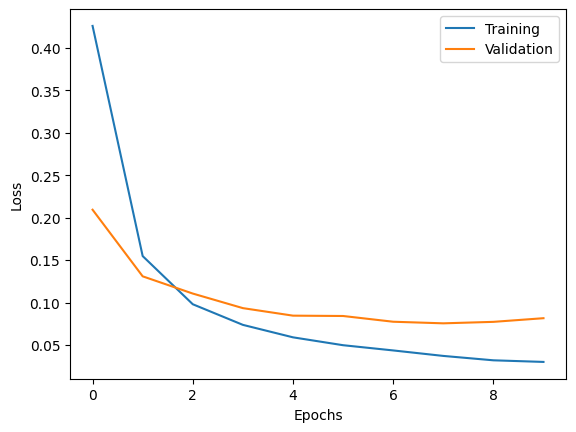

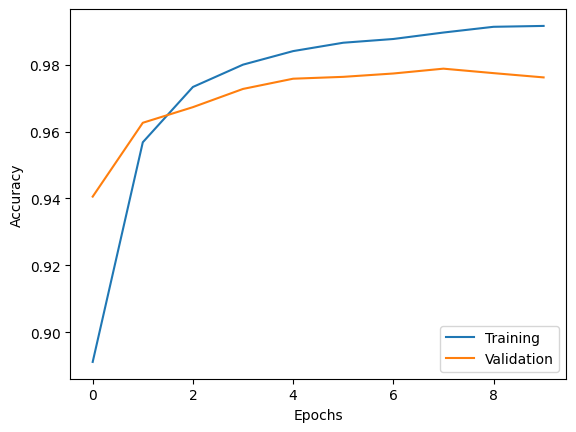

In [ ]:
plot_history(hist)

### Task 2: Evaluating - Define an `evaluate` function, with the following properties:
* It takes X_test and Y_test as arguments
* It calculates the loss, the accuracy and the classification report
* It plots the probability of being a zero for true zeros (red) and non-zeros (blue)
* It computes and plots the confusion matrix
* It plots the image, the prediction and the true value for the top 6 errors
* It plots image and predictions for the first 15 examples

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

def evaluate(X_test, Y_test):

    ##Evaluate loss and metrics
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)
    # Predict the values from the test dataset
    Y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors
    Y_cls = np.argmax(Y_pred, axis = 1)
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(Y_test, axis = 1)
    print('Classification Report:\n', classification_report(Y_true,Y_cls))

    ## Plot 0 probability
    label=0
    Y_pred_prob = Y_pred[:,label]
    plt.hist(Y_pred_prob[Y_true == label], alpha=0.5, color='red', bins=10, log = True)
    plt.hist(Y_pred_prob[Y_true != label], alpha=0.5, color='blue', bins=10, log = True)
    plt.legend(['digit == 0', 'digit != 0'], loc='upper right')
    plt.xlabel('Probability of being 0')
    plt.ylabel('Number of entries')
    plt.show()

    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_cls)
    # plot the confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(confusion_mtx, classes = range(10))

    #Plot largest errors
    errors = (Y_cls - Y_true != 0)
    Y_cls_errors = Y_cls[errors]
    Y_pred_errors = Y_pred[errors]
    Y_true_errors = Y_true[errors]
    X_test_errors = X_test[errors]
    # Probabilities of the wrong predicted numbers
    Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)
    # Predicted probabilities of the true values in the error set
    true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))
    # Difference between the probability of the predicted label and the true label
    delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors
    # Sorted list of the delta prob errors
    sorted_dela_errors = np.argsort(delta_pred_true_errors)
    # Top 6 errors
    most_important_errors = sorted_dela_errors[-6:]
    # Show the top 6 errors
    display_errors(most_important_errors, X_test_errors, Y_cls_errors, Y_true_errors)

    ##Plot predictions
    slice = 15
    predicted = model.predict(X_test[:slice]).argmax(-1)
    plt.figure(figsize=(16,8))
    for i in range(slice):
        plt.subplot(1, slice, i+1)
        plt.imshow(X_test[i].reshape(28,28), interpolation='nearest')
        plt.text(0, 0, predicted[i], color='black',
                 bbox=dict(facecolor='white', alpha=1))
        plt.axis('off')

Test Loss: 0.0660109594464302
Test Accuracy: 0.9789000153541565
313/313 [==============================] - 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.98      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



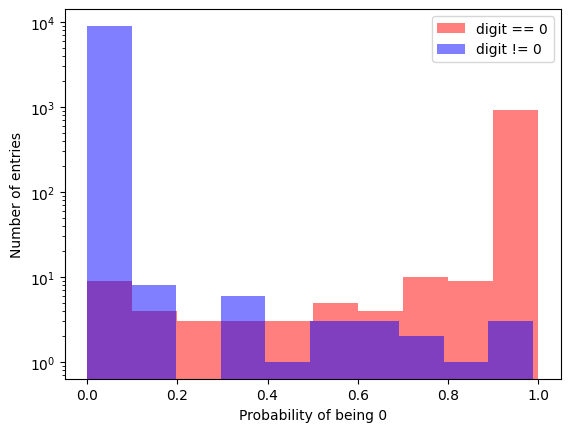

1/1 [==============================] - 0s 80ms/step


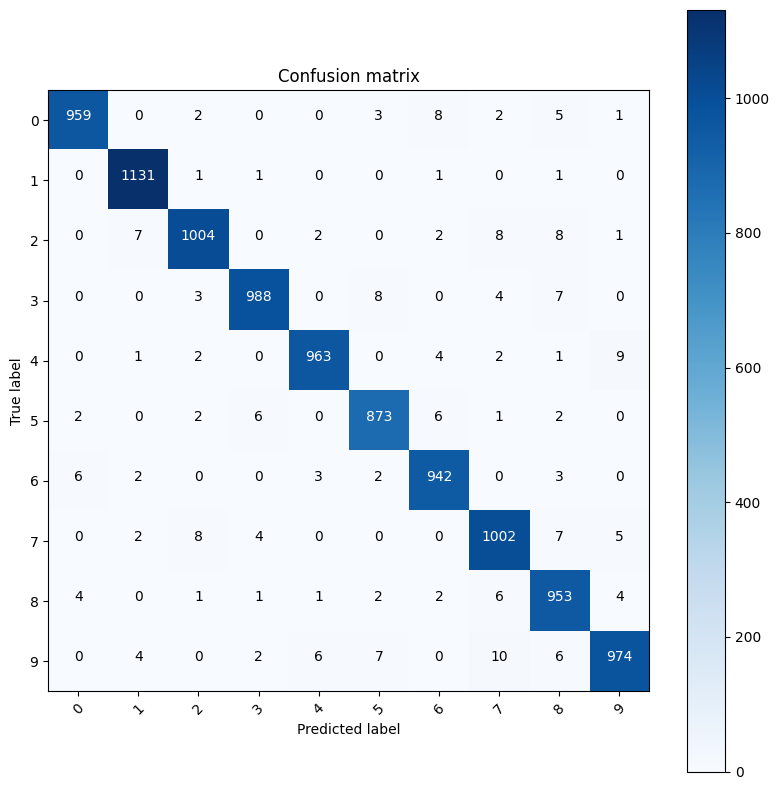

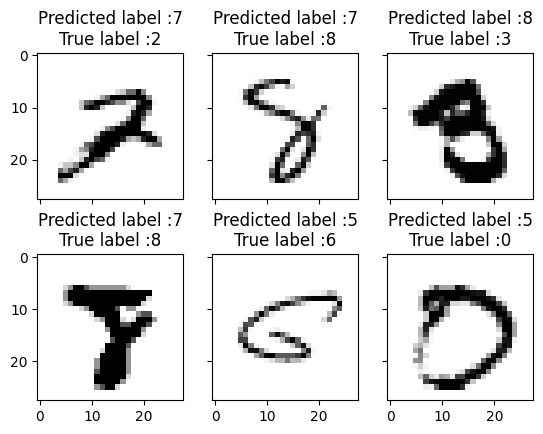

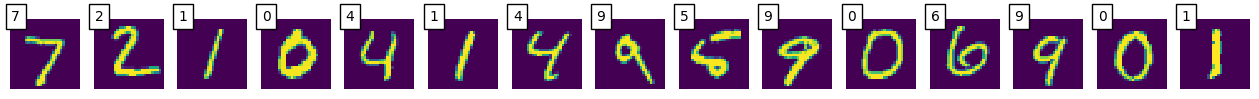

In [ ]:
evaluate(X_test, Y_test)

## Adding more Dense Layers and Dropout

### Task 3: Adding additional classification layers
* Add a dense layer between the flatten layer and the output layer
* Add a 25% dropout layer before the flatten layer
* Add a 50% dropout layer between the two dense layers
* Build the model, train the NN, plot the loss and accuracy evolution
* Evaluate the new model

In [ ]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu',
                 input_shape=shape_ord))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 dropout (Dropout)           (None, 26, 26, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 21632)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               2769024   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2770634 (10.57 MB)
Trainable params: 277

### Training

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size,
                 epochs=nb_epoch, verbose=1,
                 validation_data=(X_val, Y_val))

Epoch 1/10
165/165 [==============================] - 4s 11ms/step - loss: 0.3927 - accuracy: 0.8818 - val_loss: 0.1383 - val_accuracy: 0.9599
Epoch 2/10
165/165 [==============================] - 1s 8ms/step - loss: 0.1563 - accuracy: 0.9532 - val_loss: 0.0901 - val_accuracy: 0.9726
Epoch 3/10
165/165 [==============================] - 1s 8ms/step - loss: 0.1075 - accuracy: 0.9678 - val_loss: 0.0779 - val_accuracy: 0.9763
Epoch 4/10
165/165 [==============================] - 1s 8ms/step - loss: 0.0865 - accuracy: 0.9729 - val_loss: 0.0684 - val_accuracy: 0.9798
Epoch 5/10
165/165 [==============================] - 1s 9ms/step - loss: 0.0723 - accuracy: 0.9773 - val_loss: 0.0648 - val_accuracy: 0.9811
Epoch 6/10
165/165 [==============================] - 2s 9ms/step - loss: 0.0597 - accuracy: 0.9810 - val_loss: 0.0646 - val_accuracy: 0.9817
Epoch 7/10
165/165 [==============================] - 1s 8ms/step - loss: 0.0544 - accuracy: 0.9830 - val_loss: 0.0644 - val_accuracy: 0.9820
Epoch

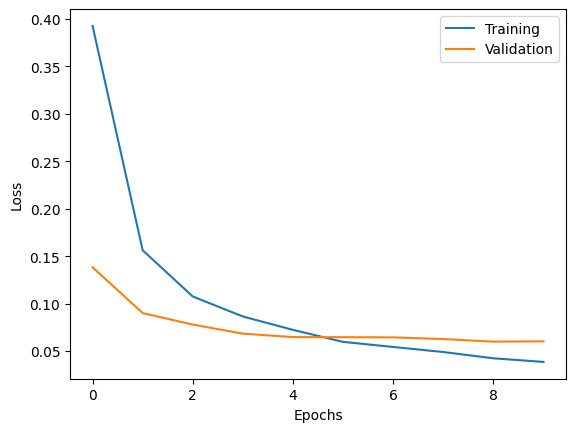

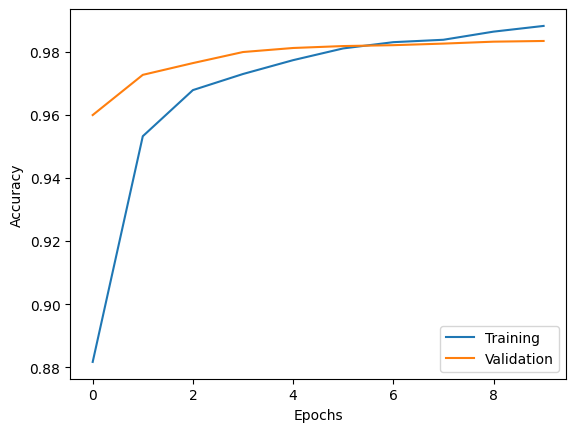

In [ ]:
plot_history(hist)

### Evaluating

Test Loss: 0.05322527512907982
Test Accuracy: 0.9829000234603882
313/313 [==============================] - 1s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.98       892
           6       0.98      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



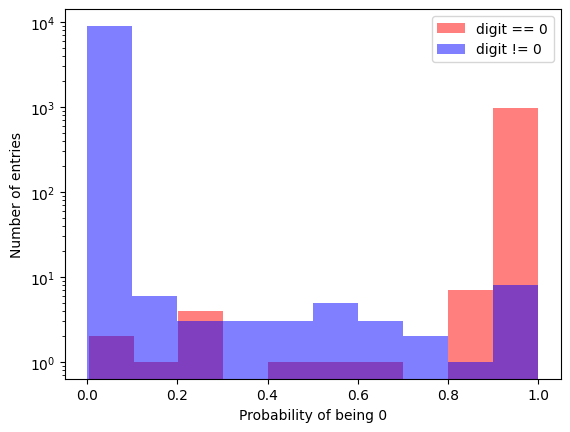

1/1 [==============================] - 0s 19ms/step


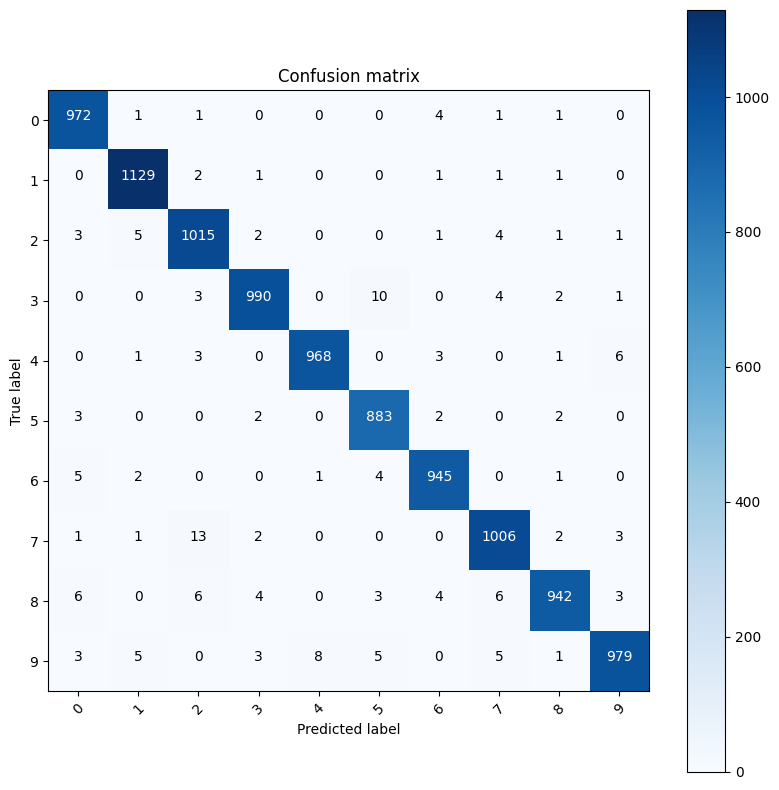

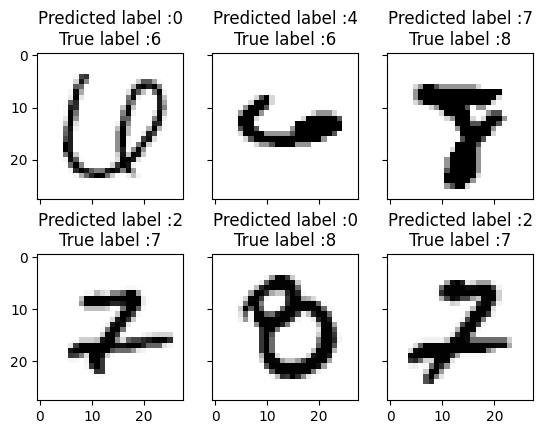

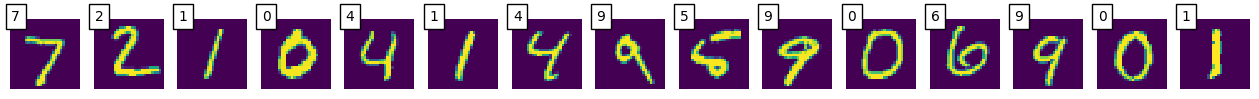

In [ ]:
# Evaluating the model on the test data
evaluate(X_test, Y_test)

# Adding an additional convolution layer and a pooling layer

### Task 4: Adding additional classification layers
* Add another `Conv2D` layer after the first convolutional layer with 64 filters, 3x3 kernel and `valid` (no) padding
* Add a `MaxPooling2D` layer with a 2x2 pooling size
* Build the model, train the NN, plot the loss and accuracy evolution
* Evaluate the new model

In [ ]:
model = Sequential()

model.add(Conv2D(nb_filters, kernel_size=(nb_conv, nb_conv), padding='same', activation='relu',
                 input_shape=shape_ord))
model.add(Conv2D(64, kernel_size=(nb_conv, nb_conv), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 64)        0         
 D)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 10816)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               1384576   
                                                      

### Training

In [ ]:
hist = model.fit(X_train, Y_train, batch_size=batch_size,
                 epochs=nb_epoch, verbose=1,
                 validation_data=(X_val, Y_val))

Epoch 1/10
165/165 [==============================] - 5s 20ms/step - loss: 0.3917 - accuracy: 0.8787 - val_loss: 0.1020 - val_accuracy: 0.9700
Epoch 2/10
165/165 [==============================] - 3s 19ms/step - loss: 0.1311 - accuracy: 0.9610 - val_loss: 0.0663 - val_accuracy: 0.9807
Epoch 3/10
165/165 [==============================] - 3s 17ms/step - loss: 0.0896 - accuracy: 0.9729 - val_loss: 0.0547 - val_accuracy: 0.9838
Epoch 4/10
165/165 [==============================] - 3s 17ms/step - loss: 0.0711 - accuracy: 0.9782 - val_loss: 0.0515 - val_accuracy: 0.9852
Epoch 5/10
165/165 [==============================] - 3s 16ms/step - loss: 0.0647 - accuracy: 0.9803 - val_loss: 0.0455 - val_accuracy: 0.9864
Epoch 6/10
165/165 [==============================] - 3s 17ms/step - loss: 0.0533 - accuracy: 0.9842 - val_loss: 0.0441 - val_accuracy: 0.9874
Epoch 7/10
165/165 [==============================] - 3s 17ms/step - loss: 0.0472 - accuracy: 0.9855 - val_loss: 0.0424 - val_accuracy: 0.9881

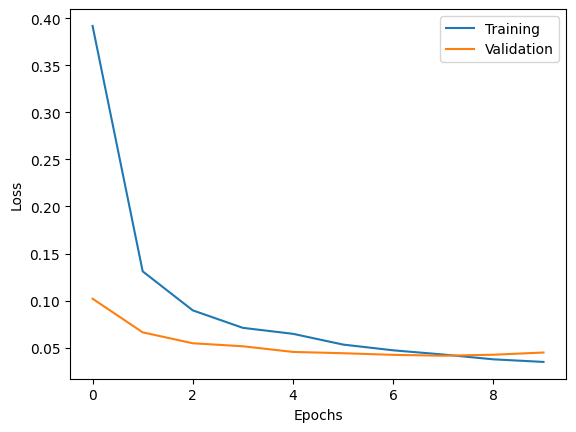

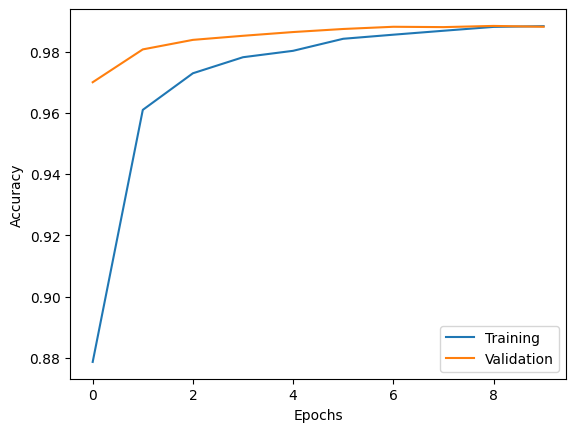

In [ ]:
plot_history(hist)

### Evaluating

Test Loss: 0.03121095523238182
Test Accuracy: 0.9901999831199646
313/313 [==============================] - 1s 3ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



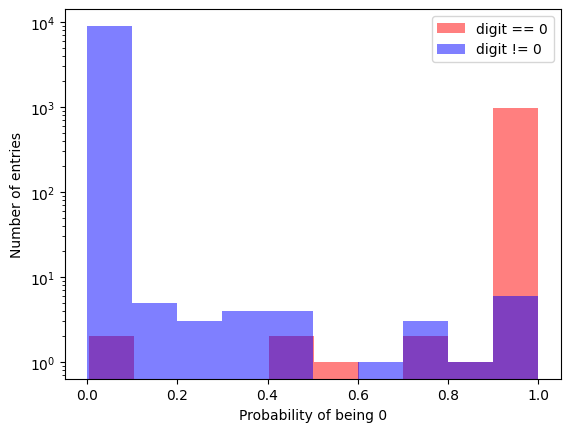

1/1 [==============================] - 0s 147ms/step


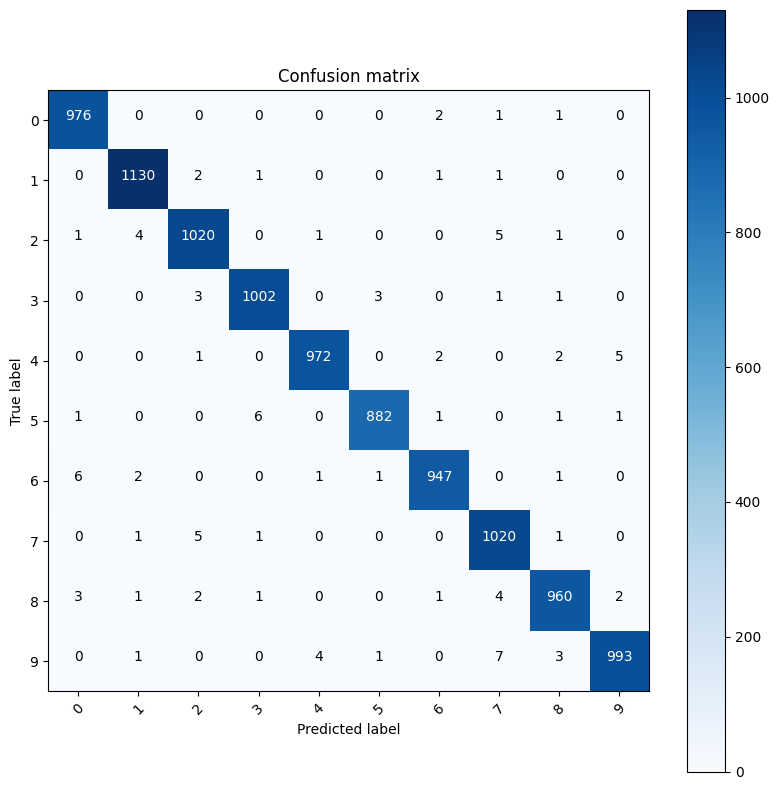

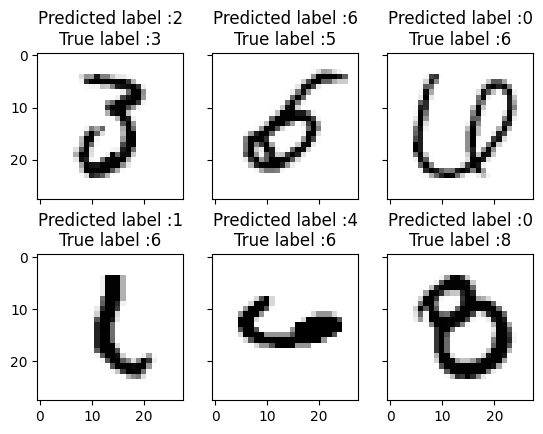

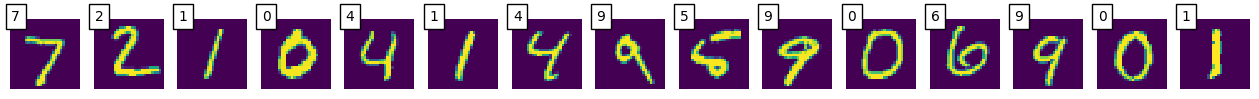

In [ ]:
evaluate(X_test, Y_test)

---

# Bonus: Understanding Convolutional Layers Structure

We will inspect and understand the convolutional layer of our previously defined quite shallow CNN, which contains two [Convolution, Convolution, MaxPooling] stages, and two Dense layers.


### Understanding layer shapes

An important feature of Keras layers is that each of them has an `input_shape` attribute, which you can use to visualize the shape of the input tensor, and an `output_shape` attribute, for inspecting the shape of the output tensor.

As we can see, the input shape of the first convolutional layer corresponds to the `input_shape` attribute (which must be specified by the user).

In this case, it is a `28x28` image with one color channel.

The first convolutional layer has the `padding` set to `same`, so its output width and height will remain the same. The number of output channel will be equal to the number of filters learned by the layer, 32.

The following convolutional layer, instead, have the default `padding`, and therefore reduce width and height by $(k-1)$, where $k$ is the size of the kernel.

`MaxPooling` layers, instead, reduce width and height of the input tensor, but keep the same number of channels.

`Activation` and `Dropout` layers, of course, don't change the shape.

In [ ]:
for i, layer in enumerate(model.layers):
    print ("Layer", i, "\t", layer.name, "\t\t", layer.input_shape, "\t", layer.output_shape)

Layer 0 	 conv2d_2 		 (None, 28, 28, 1) 	 (None, 28, 28, 32)
Layer 1 	 conv2d_3 		 (None, 28, 28, 32) 	 (None, 26, 26, 64)
Layer 2 	 max_pooling2d 		 (None, 26, 26, 64) 	 (None, 13, 13, 64)
Layer 3 	 dropout_2 		 (None, 13, 13, 64) 	 (None, 13, 13, 64)
Layer 4 	 flatten_2 		 (None, 13, 13, 64) 	 (None, 10816)
Layer 5 	 dense_3 		 (None, 10816) 	 (None, 128)
Layer 6 	 dropout_3 		 (None, 128) 	 (None, 128)
Layer 7 	 dense_4 		 (None, 128) 	 (None, 10)


### Understanding weights shape

In the same way, we can visualize the shape of the weights learned by each layer.

In particular, Keras lets you inspect weights by using the `get_weights` method of a layer object.

This will return a list with two elements, the first one being the **weight tensor** and the second one being the **bias vector**.

In particular:

- **MaxPooling layer** don't have any weight tensor, since they don't have learnable parameters.


- **Convolutional layers**, instead, learn a $(n_o, n_i, k, k)$ weight tensor, where $k$ is the size of the kernel, $n_i$ is the number of channels of the input tensor, and $n_o$ is the number of filters to be learned.

For each of the $n_o$ filters, a bias is also learned.


- **Dense layers** learn a $(n_i, n_o)$ weight tensor, where $n_o$ is the output size and $n_i$ is the input size of the layer. Each of the $n_o$ neurons also has a bias.

In [ ]:
for i, layer in enumerate(model.layers):
    if len(layer.get_weights()) > 0:
        W, b = layer.get_weights()
        print("Layer", i, "\t", layer.name, "\t\t", W.shape, "\t", b.shape)

Layer 0 	 conv2d_2 		 (3, 3, 1, 32) 	 (32,)
Layer 1 	 conv2d_3 		 (3, 3, 32, 64) 	 (64,)
Layer 5 	 dense_3 		 (10816, 128) 	 (128,)
Layer 7 	 dense_4 		 (128, 10) 	 (10,)
